In [1]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
import torch.nn as nn
from scipy.fft import fft
import keras
import torch
from torch import nn
from torch.functional import F

In [3]:
def data_generater(f, x, s, n):
    
    np.random.seed(s)
    a = np.random.rand(n)
    a = 1.0 / (a - 0.5)
    b = np.random.rand(n)
    b = 1.0 / (b - 0.5)
    c = np.random.rand(n)
    c = 1.0 / (c - 0.5)
    y = []
    for i in range(n):
        if b[i] > 0:
            if b[i]*x[0]+c[i] < 0.0:
                c[i] = 0.001
        else:
            if b[i]*x[-1]+c[i] < 0.0:
                c[i] = abs(b[i]*x[-1])
        y.append(a[i]*f(b[i]*x+c[i]))
        miny = min(y[i])
        y[i] = y[i] - miny
        maxy = max(y[i])
        y[i] = y[i] / maxy
        
    return y

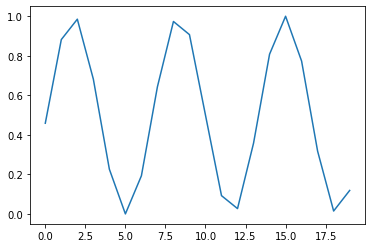

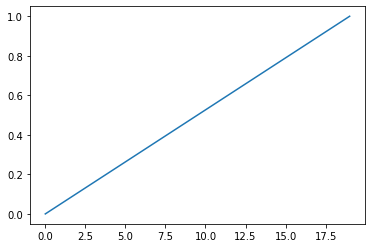

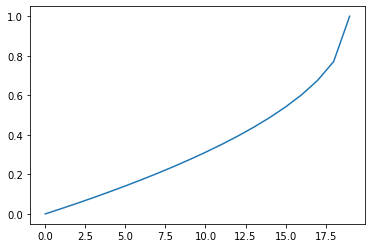

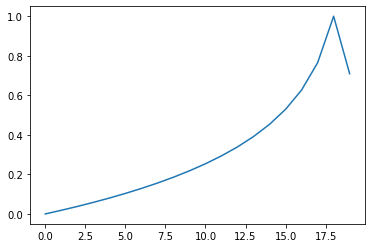

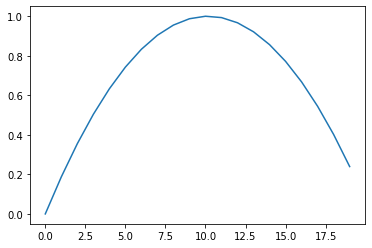

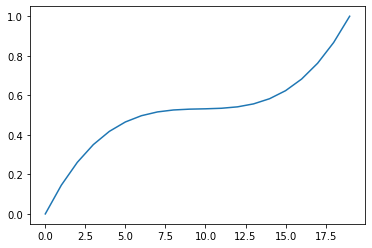

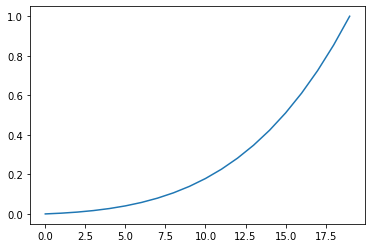

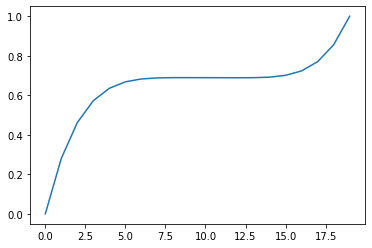

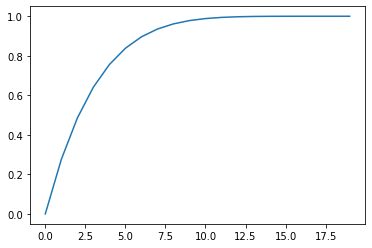

In [4]:
from gplearn.functions import make_function, _Function
from gplearn.functions import _function_map as fm
from numpy import random

const_range = (-1., 1.)

def linear(x):
    a0 = random.uniform(*const_range)
    f = x + a0
    return f

def pow_2(x):
    a1 = random.uniform(*const_range)
    a0 = random.uniform(*const_range)
    f = x ** 2 + a1 * x + a0
    return f

def pow_3(x):
    a2 = random.uniform(*const_range)
    a1 = random.uniform(*const_range)
    a0 = random.uniform(*const_range)
    f = x ** 3 + a2 * x ** 2 + a1 * x + a0
    return f
def pow_4(x):
    a3 = random.uniform(*const_range)
    a2 = random.uniform(*const_range)
    a1 = random.uniform(*const_range)
    a0 = random.uniform(*const_range)
    f = x ** 4 + a3 * x ** 3 + a2 * x ** 2 + a1 * x + a0
    return f
    
def pow_5(x):
    a4 = random.uniform(*const_range)
    a3 = random.uniform(*const_range)
    a2 = random.uniform(*const_range)
    a1 = random.uniform(*const_range)
    a0 = random.uniform(*const_range)
    f = x ** 5 + a4 * x ** 4 + a3 * x ** 3 + a2 * x ** 2 + a1 * x + a0
    return f
    
def pow_6(x):
    a5 = random.uniform(*const_range)
    a4 = random.uniform(*const_range)
    a3 = random.uniform(*const_range)
    a2 = random.uniform(*const_range)
    a1 = random.uniform(*const_range)
    a0 = random.uniform(*const_range)
    f = x ** 6 + a5 * x ** 5 + a4 * x ** 4 + a3 * x ** 3 + a2 * x ** 2 + a1 * x + a0
    return f

linear = make_function(function=linear,name='lin',arity=1)
pow_2 = make_function(function=pow_2,name='pow2',arity=1)
pow_3 = make_function(function=pow_3,name='pow3',arity=1)
pow_4 = make_function(function=pow_4,name='pow4',arity=1)
pow_5 = make_function(function=pow_5,name='pow5',arity=1)
pow_6 = make_function(function=pow_6,name='pow6',arity=1)

function_set = ['sin', linear, 'sqrt', 'log', pow_2, pow_3, pow_4, pow_5, pow_6]

n_fun = len(function_set)


flabel = np.zeros((n_fun, n_fun))
for i in range(n_fun):
    flabel[i, i] = 1

    
ylabel = []
ys = []
n_s = 35000
n_Fs = 0
# Number of sample points
n_data = 20
x = np.linspace(-2.0, 2.0, n_data, endpoint=False)
seed = 42
for i in range(n_fun):
    f = function_set[i]
    if isinstance(f, _Function):
        function = f
    else:
        function = fm[f]
    if function.name in ['sin', 'tan']:
        y = data_generater(function, x, seed, n_s)
    else:
        y = data_generater(function, x, seed, n_s)
        
    n_Fs += 1
    ylabel.append(flabel[i])
    ys.append(y)
    plt.plot(y[4])
    plt.show()
    seed += 1

In [5]:
import random

s=list(range(n_Fs*n_s))
random.shuffle(s)

train_y = []
train_lf = []
train_lo = []

test_y = []
test_lf = []
test_lo = []

train_test_ratio = 0.9

n_train = int(len(s)*train_test_ratio)
n_test = len(s) - n_train

for k in range(n_train):
    m = s[k]
    j = int(m/n_Fs)
    i = m % n_Fs
    train_y.append(ys[i][j])
    train_lf.append(ylabel[i])

for k in range(n_train, len(s)):
    m = s[k]
    j = int(m/n_Fs)
    i = m % n_Fs
    test_y.append(ys[i][j])
    test_lf.append(ylabel[i])


In [6]:
train_y = np.asarray(train_y).reshape(n_train, n_data, 1)
train_lf = np.asarray(train_lf).reshape(n_train, n_fun)

test_y = np.asarray(test_y).reshape(n_test, n_data, 1)
test_lf = np.asarray(test_lf).reshape(n_test, n_fun)

In [7]:
batch_size = 16

train_dataset = (tf.data.Dataset.from_tensor_slices(np.float32(train_y)).batch(batch_size))
train_dataset_lf = (tf.data.Dataset.from_tensor_slices(np.float32(train_lf)).batch(batch_size))

test_dataset = (tf.data.Dataset.from_tensor_slices(np.float32(test_y)).batch(batch_size))
test_dataset_lf = (tf.data.Dataset.from_tensor_slices(np.float32(test_lf)).batch(batch_size))

In [8]:
class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [   
                tf.keras.layers.InputLayer(input_shape=(n_data, 1)),
                tf.keras.layers.Conv1D(filters=8, kernel_size=7, strides=1, padding='same', activation='sigmoid'),
                tf.keras.layers.Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='sigmoid'),
                
                tf.keras.layers.Flatten(),
                # No activation
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=n_data*32, activation=tf.nn.sigmoid),
                tf.keras.layers.Reshape(target_shape=(n_data, 32)),
                tf.keras.layers.Conv1DTranspose(
                    filters=16, kernel_size=3, strides=1, padding='same',
                    activation='sigmoid'),
                tf.keras.layers.Conv1DTranspose(
                    filters=8, kernel_size=7, strides=1, padding='same',
                    activation='sigmoid'),
                
                # No activation
                tf.keras.layers.Conv1DTranspose(
                    filters=1, kernel_size=1, strides=1, padding='same'),
            ]
        )
        

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(n_data, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits
    
    def latent(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        return z

In [9]:
tfd = tfp.distributions
tfpl = tfp.layers

In [10]:
class BAYES_CLASSIFIER_fun(tf.keras.Model):
    def __init__(self, latent_dim, n_fun, n_train=10000, hidden=500):
        super(BAYES_CLASSIFIER_fun, self).__init__()
        self.latent_dim = latent_dim
        self.n_fun = n_fun
        self.divergence_fn = lambda q,p,_:tfd.kl_divergence(q,p)/n_train
        self.classifier = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim, )),
                tfpl.DenseReparameterization(units=hidden, activation='sigmoid',
                                           kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                           kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                           kernel_divergence_fn = self.divergence_fn,
                                           bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                           bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                           bias_divergence_fn = self.divergence_fn),
                tf.keras.layers.Dense(units=hidden, activation=tf.nn.sigmoid),
                tf.keras.layers.Dense(units=hidden, activation=tf.nn.sigmoid),
                #tfpl.DenseReparameterization(units=tfpl.OneHotCategorical.params_size(n_fun), activation=tf.nn.sigmoid, #activation=None,
                tfpl.DenseReparameterization(units=n_fun, activation=None, #activation=tf.nn.sigmoid,                         
                                    kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                    kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                    kernel_divergence_fn = self.divergence_fn,
                                    bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                    bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                    bias_divergence_fn = self.divergence_fn
                                )
            ]
        )
        
    
    def classify_logits(self, z, threshold=0.5):
        logits = self.classifier(z)
        return logits
    
    def classify_hot(self, z, threshold=0.5):
        logits = self.classifier(z)
        prediction = tf.sigmoid(logits)
        #prediction = tfpl.OneHotCategorical(prediction)
        onehot = tfpl.OneHotCategorical(n_fun, convert_to_tensor_fn=tfd.Distribution.mode)
        prediction = onehot(prediction)
        #prediction = self.classifier(z)
        #prediction = tf.cast(prediction, tf.float32)
            
        return prediction #tf.cast(tf.greater(prediction, threshold), tf.int64)

In [11]:
from tensorflow.keras.optimizers import Adam

optimizer_fn = Adam(1e-4)

def get_metrics(labels_tensor, one_hot_prediction, num_classes):
    metrics = {}
    with tf.variable_scope("metrics"):
        for scope in ["train", "val"]:
            with tf.variable_scope(scope):
                with tf.variable_scope("f1"):
                    f1s, f1_updates = streaming_f1(
                        labels_tensor,
                        one_hot_prediction,
                        num_classes,
                    )
                    micro_f1, macro_f1, weighted_f1 = f1s
                with tf.variable_scope("accuracy"):
                    accuracy, accuracy_update = tf.metrics.accuracy(
                        tf.cast(one_hot_prediction, tf.int32),
                        labels_tensor,
                    )
                metrics[scope] = {
                    "accuracy": accuracy,
                    "f1": {
                        "micro": micro_f1,
                        "macro": macro_f1,
                        "weighted": weighted_f1,
                    },
                    "updates": tf.group(f1_updates, accuracy_update),
                }
    return metrics

def compute_classifier_fun_loss(CVAE, BCLASS_fn, x, label_fn):
    z = CVAE.latent(x)
    logits_fn = BCLASS_fn.classify_logits(z)
    loss_fn = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fn, labels=label_fn)
    # loss has the same shape as logits: 1 loss per class and per sample in the batch
    loss_fn = tf.reduce_mean(
        tf.reduce_sum(loss_fn, axis=1)
    )
    
    return loss_fn


@tf.function
def classifier_fun_train_step(CVAE, BCLASS_fn, x, label_fn, optimizer):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape_fn:
        loss_fn = compute_classifier_fun_loss(CVAE, BCLASS_fn, x, label_fn)
    gradients_fn = tape_fn.gradient(loss_fn, BCLASS_fn.trainable_variables)
    optimizer_fn.apply_gradients(zip(gradients_fn, BCLASS_fn.trainable_variables))
    


In [12]:
optimizer = Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)


def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)


def compute_loss_train(model, BCLASS_fn, x, y):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    
    logits_fn = BCLASS_fn.classify_logits(z)
    loss_fn = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fn, labels=y)
    # loss has the same shape as logits: 1 loss per class and per sample in the batch
    loss_fn = tf.reduce_mean(
        tf.reduce_sum(loss_fn, axis=1)
    )
    
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x) + loss_fn


@tf.function
def train_step(model, BCLASS_fn, x, y, optimizer, optimizer_fn):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = compute_loss_train(model, BCLASS_fn, x, y)
        grads = tape.gradient(loss, model.trainable_variables + BCLASS_fn.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables + BCLASS_fn.trainable_variables))

In [13]:
epochs = 1500
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 15
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
BCLASS_fn = BAYES_CLASSIFIER_fun(latent_dim, n_fun, n_train)


/home/shahab/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [14]:
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
CVAE_model = CVAE(latent_dim)

In [15]:
def generate_and_save_function(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.plot(predictions[i, :, -1])
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('Results/functions_at_epoch_{:04d}_run_5.png'.format(epoch))
    plt.show()


In [49]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(7):
    test_sample = test_batch[0:num_examples_to_generate, :, :]

test data


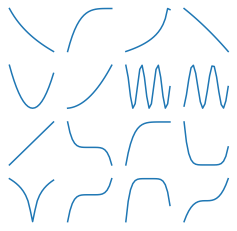

model generated


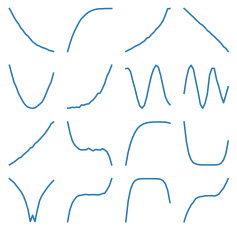

In [54]:
fig = plt.figure(figsize=(4, 4))

for i in range(test_sample.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.plot(test_sample[i, :, -1])
    plt.axis('off')

print("test data")
plt.show()
print("model generated")
generate_and_save_function(CVAE_model, 1501, test_sample)

Epoch: 1500, Test set ELBO: -11.963287353515625, Test set fn loss: 0.7655511498451233, time elapse for current epoch: 38.85183000564575


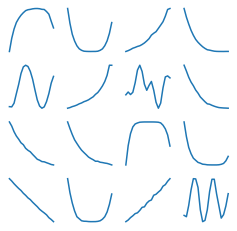

In [20]:
generate_and_save_function(CVAE_model, 1251, test_sample)

for epoch in range(1251, epochs + 1):
    start_time = time.time()
    for train_f, label_f in zip(train_dataset, train_dataset_lf):
        train_step(CVAE_model, BCLASS_fn, train_f, label_f, optimizer, optimizer_fn)
    end_time = time.time()

    loss = tf.keras.metrics.Mean()
    loss_fn = tf.keras.metrics.Mean()
    for test_f, test_lf in zip(test_dataset, test_dataset_lf):
        loss(compute_loss(CVAE_model, test_f))
        loss_fn(compute_classifier_fun_loss(CVAE_model, BCLASS_fn, test_f, test_lf))
        
        
    elbo = -loss.result()
    loss_fn = loss_fn.result()
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, Test set fn loss: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, loss_fn, end_time - start_time))
    generate_and_save_function(CVAE_model, epoch, test_sample)
    
    if epoch % 50 == 0:
        CVAE_model.save_weights('Results/saved_models/f_model_at_epoch_{:04d}'.format(epoch))
        BCLASS_fn.save_weights('Results/saved_models/Bayes_fn_model_at_epoch_{:04d}'.format(epoch))



In [75]:
#CVAE_model.save_weights('Results/saved_models/f_model')

CVAE_model.load_weights('Results/saved_models/f_model_at_epoch_1500')

In [76]:
#BCLASS_fn.save_weights('Results/saved_models/Bayes_fn_model')

BCLASS_fn.load_weights('Results/saved_models/Bayes_fn_model_at_epoch_1500')

In [89]:
def plot_latent_functions(model, n):
    """Plots n x n digit functions decoded from the latent space."""

    norm = tfp.distributions.Normal(0, 1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_z = norm.quantile(np.linspace(0.05, 0.95, n))
    fig, axs = plt.subplots(n*n, n, sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0, 'wspace': 0})
    
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            for k, zi in enumerate(grid_z):
                p = np.array([[xi, yi, zi]])
                x_decoded = model.sample(p)
                digit = tf.reshape(x_decoded[0], (n_data))
                axs[i*n+j][k].plot(digit.numpy())

    plt.axis('Off')
    plt.show()

ValueError: in user code:

    <ipython-input-8-9995149d3571>:42 sample  *
        return self.decode(eps, apply_sigmoid=True)
    <ipython-input-8-9995149d3571>:53 decode  *
        logits = self.decoder(z)
    /home/shahab/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__  **
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/shahab/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:255 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_2 is incompatible with the layer: expected axis -1 of input shape to have value 15 but received input with shape (1, 3)


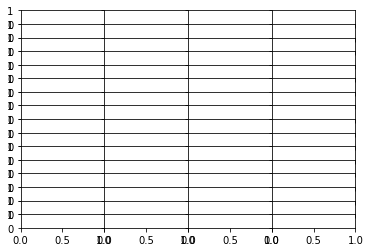

In [23]:
plot_latent_functions(CVAE_model, 4)

In [212]:
from gplearn.functions import sqrt1, log1, inv1
from sklearn.utils import check_random_state

def benchmarks():
    nsample = 20
    rng = check_random_state(0)
    f = []
    
    x = rng.uniform(-10, 10, 1000)
    x = rng.uniform(-10, 10, nsample)
    x.sort()
    f.append([x, 1.0/3.0 + x + np.sin(x**2), 'L1'])
    
    x = rng.uniform(-1, 1, nsample)
    x.sort()
    f.append([x, np.sin(x**2)*np.cos(x) - 2.0, 'L2'])
    
    x = rng.uniform(-1, 1, nsample)
    x.sort()
    f.append([x, np.sin(x**3)*np.cos(x**2) - 1, 'L3'])
    
    x = rng.uniform(0, 2, nsample)
    x.sort()
    f.append([x, np.log(x + 1) + np.log(x**2 + 1) + np.log(x), 'L4'])
    
    #x = rng.uniform(0, 1, nsample*2).reshape(nsample, 2)
    #f.append([x, x[:,0]**4 - x[:,0]**3 + x[:,0]**2 - x[:,1], 'L5'])
    
    x = rng.uniform(-1, 1, nsample)
    x.sort()
    f.append([x, 4.0*x**4 + 3*x**3 + 2*x**2 + x, 'L6'])
    
    x = rng.uniform(-1, 1, nsample)
    x.sort()
    f.append([x, np.sinh(x), 'L7'])
    
    x = rng.uniform(-1, 1, nsample)
    x.sort()
    f.append([x, np.cosh(x), 'L8'])
    
    x = rng.uniform(-1, 1, nsample)
    x.sort()
    f.append([x, x + x**2 + x**3 + x**4 + x**5 + x**6 + x**7 + x**8 + x**9, 'L9'])
    
    #x = rng.uniform(0, 1, nsample*2).reshape(nsample, 2)
    #f.append([x, 6*np.sin(x[:,0])*np.cos(x[:,1]), 'L10'])
    
    #x = rng.uniform(-1, 1, 50*2).reshape(50, 2)
    #f.append([x, x[:,0]**2*x[:,1]**2/(x[:,0]+x[:,1]), 'L11'])
    
    #x = rng.uniform(-1, 1, 50*2).reshape(50, 2)
    #x = rng.uniform(-1, 1, nsample*2).reshape(nsample, 2)
    #f.append([x, x[:,0]**5/x[:,1]**3, 'L12'])
    
    x = rng.uniform(0, 4, nsample)
    x.sort()
    f.append([x, x**(1.0/3.0), 'L13'])    
    
    x = rng.uniform(-1, 1, nsample)
    x.sort()
    f.append([x, x + x**2 + x**3 + np.sin(x) + np.sin(x**2), 'L14'])
    
    x = rng.uniform(0, 4, nsample)
    x.sort()
    f.append([x, x**(1.0/5.0), 'L15'])
    
    x = rng.uniform(0, 4, nsample)
    x.sort()
    f.append([x, x**(1.0/5.0), 'L16'])
    
    #x = rng.uniform(0, 1, nsample*2).reshape(nsample, 2)
    #f.append([x, 4.0*np.sin(x[:,0])*np.cos(x[:,1]), 'L17'])
    
    x = rng.uniform(-1, 1, nsample)
    x.sort()
    f.append([x, np.sin(x**2)*np.cos(x) - 5.0, 'L18'])
    
    x = rng.uniform(-1, 1, nsample)
    x.sort()
    f.append([x, x + x**2 + x**4 + x**5, 'L19'])
    
    x = rng.uniform(-1, 1, nsample)
    x.sort()
    f.append([x, np.exp(-1*x**2), 'L20'])
    
    x = rng.uniform(-1, 1, nsample)
    x.sort()
    f.append([x, x + x**2 + x**3 + x**4 + x**5 + x**6 + x**7 + x**8, 'L21'])
    
    x = rng.uniform(-1, 1, nsample)
    x.sort()
    f.append([x, np.exp(-0.5*x**2), 'L22'])
       
    x = rng.uniform(-1, 1, nsample)
    x.sort()
    f.append([x, (x + 1.0)**3/(x**2 - x + 1), 'R1'])

    x = rng.uniform(-1, 1, nsample)
    x.sort()
    f.append([x, (x**5 - 3.0*x**3 + 1.0)/(x**2 + 1), 'R2'])

    x = rng.uniform(-1, 1, nsample)
    x.sort()
    f.append([x, (x**6 + x**5)/(x**4 + x**3 + x**2 + x + 1), 'R3'])

    x = rng.uniform(-1, 1, nsample)
    x.sort()
    f.append([x, x + x**2 + x**3, 'N1'])

    x = rng.uniform(-1, 1, nsample)
    x.sort()
    f.append([x, x + x**2 + x**3 + x**4, 'N2'])

    x = rng.uniform(-1, 1, nsample)
    x.sort()
    f.append([x, x + x**2 + x**3 + x**4 + x**5, 'N3'])

    x = rng.uniform(-1, 1, nsample)
    x.sort()
    f.append([x, x + x**2 + x**3 + x**4 + x**5 + x**6, 'N4'])

    x = rng.uniform(-1, 1, nsample)
    x.sort()
    f.append([x, np.sin(x**2)*np.cos(x) - 1, 'N5'])

    x = rng.uniform(-1, 1, nsample)
    x.sort()
    f.append([x, x + x**2 + x**3, 'N6'])

    x = rng.uniform(0, 2, nsample)
    x.sort()
    f.append([x, np.log(x + 1) + np.log(x**2 + 1), 'N7'])

    x = rng.uniform(0, 4, nsample)
    x.sort()
    f.append([x, np.sqrt(x), 'N8'])

    #x = rng.uniform(0, 1, nsample*2).reshape(nsample, 2)
    #f.append([x, np.sin(x[:,0]) + np.sin((x[:,1])**2), 'N9'])

    #x = rng.uniform(0, 1, nsample*2).reshape(nsample, 2)
    #f.append([x, 2*np.sin(x[:,0])*np.cos(x[:,1]), 'N10'])

    #x = rng.uniform(0, 1, nsample*2).reshape(nsample, 2)
    #f.append([x, (x[:,0])**x[:,1], 'N11'])

    #x = rng.uniform(0, 1, nsample*2).reshape(nsample, 2)
    #f.append([x, (x[:,0])**4 - (x[:,0])**3 + 0.5/(x[:,1])**2 - x[:,1], 'N12'])
    return f

def benchmarks__():
    nsample = 20
    rng = check_random_state(0)
    f = []
    
    x = np.linspace(-10, 10, nsample)
    f.append([x, 1.0/3.0 + x + np.sin(x**2), 'L1'])
    
    x = np.linspace(-1, 1, nsample)
    x.sort()
    f.append([x, np.sin(x**2)*np.cos(x) - 2.0, 'L2'])
    
    x = np.linspace(-1, 1, nsample)
    x.sort()
    f.append([x, np.sin(x**3)*np.cos(x**2) - 1, 'L3'])
    
    x = np.linspace(0, 2, nsample)
    x.sort()
    f.append([x, np.log(x + 1) + np.log(x**2 + 1) + np.log(x), 'L4'])
    
    #x = rng.uniform(0, 1, nsample*2).reshape(nsample, 2)
    #f.append([x, x[:,0]**4 - x[:,0]**3 + x[:,0]**2 - x[:,1], 'L5'])
    
    x = np.linspace(-1, 1, nsample)
    x.sort()
    f.append([x, 4.0*x**4 + 3*x**3 + 2*x**2 + x, 'L6'])
    
    x = np.linspace(-1, 1, nsample)
    x.sort()
    f.append([x, np.sinh(x), 'L7'])
    
    x = np.linspace(-1, 1, nsample)
    x.sort()
    f.append([x, np.cosh(x), 'L8'])
    
    x = np.linspace(-1, 1, nsample)
    x.sort()
    f.append([x, x + x**2 + x**3 + x**4 + x**5 + x**6 + x**7 + x**8 + x**9, 'L9'])
    
    #x = rng.uniform(0, 1, nsample*2).reshape(nsample, 2)
    #f.append([x, 6*np.sin(x[:,0])*np.cos(x[:,1]), 'L10'])
    
    #x = rng.uniform(-1, 1, 50*2).reshape(50, 2)
    #f.append([x, x[:,0]**2*x[:,1]**2/(x[:,0]+x[:,1]), 'L11'])
    
    #x = rng.uniform(-1, 1, 50*2).reshape(50, 2)
    #x = rng.uniform(-1, 1, nsample*2).reshape(nsample, 2)
    #f.append([x, x[:,0]**5/x[:,1]**3, 'L12'])
    
    x = np.linspace(0, 4, nsample)
    x.sort()
    f.append([x, x**(1.0/3.0), 'L13'])    
    
    x = np.linspace(-1, 1, nsample)
    x.sort()
    f.append([x, x + x**2 + x**3 + np.sin(x) + np.sin(x**2), 'L14'])
    
    x = np.linspace(0, 4, nsample)
    x.sort()
    f.append([x, x**(1.0/5.0), 'L15'])
    
    x = np.linspace(0, 4, nsample)
    x.sort()
    f.append([x, x**(1.0/5.0), 'L16'])
    
    #x = rng.uniform(0, 1, nsample*2).reshape(nsample, 2)
    #f.append([x, 4.0*np.sin(x[:,0])*np.cos(x[:,1]), 'L17'])
    
    x = np.linspace(-1, 1, nsample)
    x.sort()
    f.append([x, np.sin(x**2)*np.cos(x) - 5.0, 'L18'])
    
    x = np.linspace(-1, 1, nsample)
    x.sort()
    f.append([x, x + x**2 + x**4 + x**5, 'L19'])
    
    x = np.linspace(-1, 1, nsample)
    x.sort()
    f.append([x, np.exp(-1*x**2), 'L20'])
    
    x = np.linspace(-1, 1, nsample)
    x.sort()
    f.append([x, x + x**2 + x**3 + x**4 + x**5 + x**6 + x**7 + x**8, 'L21'])
    
    x = np.linspace(-1, 1, nsample)
    x.sort()
    f.append([x, np.exp(-0.5*x**2), 'L22'])
       
    x = np.linspace(-1, 1, nsample)
    x.sort()
    f.append([x, (x + 1.0)**3/(x**2 - x + 1), 'R1'])

    x = np.linspace(-1, 1, nsample)
    x.sort()
    f.append([x, (x**5 - 3.0*x**3 + 1.0)/(x**2 + 1), 'R2'])

    x = np.linspace(-1, 1, nsample)
    x.sort()
    f.append([x, (x**6 + x**5)/(x**4 + x**3 + x**2 + x + 1), 'R3'])

    x = np.linspace(-1, 1, nsample)
    x.sort()
    f.append([x, x + x**2 + x**3, 'N1'])

    x = np.linspace(-1, 1, nsample)
    x.sort()
    f.append([x, x + x**2 + x**3 + x**4, 'N2'])

    x = np.linspace(-1, 1, nsample)
    x.sort()
    f.append([x, x + x**2 + x**3 + x**4 + x**5, 'N3'])

    x = np.linspace(-1, 1, nsample)
    x.sort()
    f.append([x, x + x**2 + x**3 + x**4 + x**5 + x**6, 'N4'])

    x = np.linspace(-1, 1, nsample)
    x.sort()
    f.append([x, np.sin(x**2)*np.cos(x) - 1, 'N5'])

    x = np.linspace(-1, 1, nsample)
    x.sort()
    f.append([x, x + x**2 + x**3, 'N6'])

    x = np.linspace(0, 2, nsample)
    x.sort()
    f.append([x, np.log(x + 1) + np.log(x**2 + 1), 'N7'])

    x = np.linspace(0, 4, nsample)
    x.sort()
    f.append([x, np.sqrt(x), 'N8'])

    #x = rng.uniform(0, 1, nsample*2).reshape(nsample, 2)
    #f.append([x, np.sin(x[:,0]) + np.sin((x[:,1])**2), 'N9'])

    #x = rng.uniform(0, 1, nsample*2).reshape(nsample, 2)
    #f.append([x, 2*np.sin(x[:,0])*np.cos(x[:,1]), 'N10'])

    #x = rng.uniform(0, 1, nsample*2).reshape(nsample, 2)
    #f.append([x, (x[:,0])**x[:,1], 'N11'])

    #x = rng.uniform(0, 1, nsample*2).reshape(nsample, 2)
    #f.append([x, (x[:,0])**4 - (x[:,0])**3 + 0.5/(x[:,1])**2 - x[:,1], 'N12'])
    return f


def single_data(f):
    
    y = f[1]
    miny = min(y)
    y = y - miny
    maxy = max(y)
    y = y / maxy
        
    return y


data2 = benchmarks__()

for d in data2:
    d[1] = single_data(d)

<ipython-input-212-714b7b6af4b7>:169: RuntimeWarning: divide by zero encountered in log
  f.append([x, np.log(x + 1) + np.log(x**2 + 1) + np.log(x), 'L4'])
<ipython-input-212-714b7b6af4b7>:301: RuntimeWarning: invalid value encountered in subtract
  y = y - miny


In [115]:
x = rng.uniform(-1, 1, 50*2).reshape(50, 2)
g = x[:,0]**5/x[:,1]**3
print(max(abs(g)), min(abs(g)))

21238.65280166262 1.7809849555004717e-10


In [163]:
from gplearn.functions import sqrt1, log1, inv1
from sklearn.utils import check_random_state

def benchmarks():
    nsample = 20
    rng = check_random_state(0)
    f = []
           
    x = rng.uniform(-10, 10, nsample)
    x.sort()
    f.append([x, (x + 1.0)**3/(x**2 - x + 1), 'R1'])

    x = rng.uniform(-10, 10, nsample)
    x.sort()
    f.append([x, (x**5 - 3.0*x**3 + 1.0)/(x**2 + 1), 'R2'])

    x = rng.uniform(-10, 10, nsample)
    x.sort()
    f.append([x, (x**6 + x**5)/(x**4 + x**3 + x**2 + x + 1), 'R3'])

    return f

def benchmark_():
    nsample = 20
    rng = check_random_state(0)
    f = []
           
    x = rng.uniform(-2, 2, nsample)
    x = np.linspace(-2, 2, nsample)
    x.sort()
    f.append([x, 0.3*x*np.sin(2*np.pi*x), 'VUMC'])

    return f

def single_data(f):
    
    y = f[1]
    miny = min(y)
    y = y - miny
    maxy = max(y)
    y = y / maxy
        
    return y


data = benchmark_()

for d in data:
    d[1] = single_data(d)

In [225]:
x = np.linspace(0.001, 7, 20)
data4 = [[x, np.sin(x), 'L4']]

for d in data4:
    d[1] = single_data(d)

In [226]:
predicted_probabilities_fn = np.empty(shape=(300, n_fun))

for d in data4:
    print(d[2])
    y = d[1]
    for i in range(300):
        z = CVAE_model.latent(np.asarray(y).reshape(1,n_data,1))
        logits_lf = BCLASS_fn.classify_logits(z) 
        pr_fn = BCLASS_fn.classify_hot(z, logits_lf).mean().numpy()[0]
        predicted_probabilities_fn[i] = pr_fn
        
    pct_2p5_fn = np.array([np.percentile(predicted_probabilities_fn[:, i], 2.5) for i in range(n_fun)])
    pct_97p5_fn = np.array([np.percentile(predicted_probabilities_fn[:, i], 97.5) for i in range(n_fun)])
    
    d.append(pct_2p5_fn)
    d.append(pct_97p5_fn)

L4


L4
prior = {'sin':0.25, 'affine':0.10, 'sqrt':0.10, 'log':0.10, 2:0.10, 3:0.10, 4:0.10, 5:0.24, 6:0.10}
prior_25 = {'sin':0.10, 'affine':0.09, 'sqrt':0.09, 'log':0.09, 2:0.09, 3:0.09, 4:0.09, 5:0.09, 6:0.09}
& 0.25 & 0.10 & 0.10 & 0.10 & 0.10 & 0.10 & 0.10 & 0.24 & 0.10 


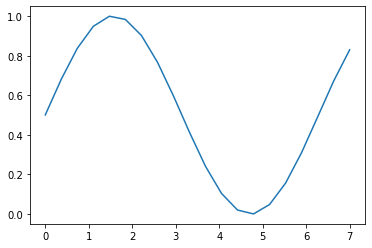

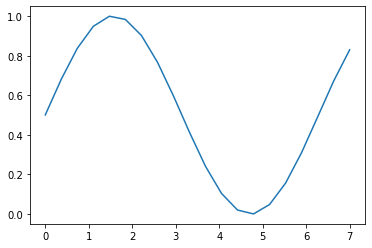

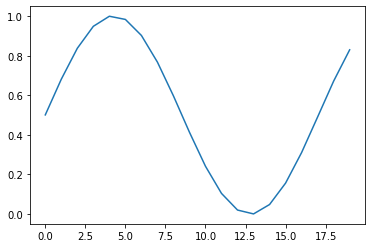

In [228]:
for (d, d1) in zip(data4, data4):
    print(d[2])
    latex = '& {:.2f} '.format(d[4][0]) + '& {:.2f} '.format(d[4][3]) + \
            '& {:.2f} '.format(d[4][2]) + '& {:.2f} '.format(d[4][1]) + \
            '& {:.2f} '.format(d[4][4]) + '& {:.2f} '.format(d[4][5]) + \
            '& {:.2f} '.format(d[4][6]) + '& {:.2f} '.format(d[4][7]) + \
            '& {:.2f} '.format(d[4][8])
    priors = 'prior = {'
    priors_25 = 'prior_25 = {'
    for i in range(len(function_set)):
        if isinstance(function_set[i], _Function):
            if function_set[i].name == 'lin':
                priors += "'affine'" + ':{:.2f}'.format(d[4][i]) + ', '
                priors_25 += "'affine'" + ':{:.2f}'.format(d[3][i]) + ', '
            elif function_set[i].name[:3] == 'pow':
                priors += function_set[i].name[3] + ':{:.2f}'.format(d[4][i]) + ', '
                priors_25 += function_set[i].name[3] + ':{:.2f}'.format(d[3][i]) + ', '
            else:
                priors += "'" + function_set[i].name + "'" + ':{:.2f}'.format(d[4][i]) + ', ' 
                priors_25 += "'" + function_set[i].name + "'" + ':{:.2f}'.format(d[3][i]) + ', ' 
        else:
            priors += "'" + function_set[i] + "'" + ':{:.2f}'.format(d[4][i]) + ', '
            priors_25 += "'" + function_set[i] + "'" + ':{:.2f}'.format(d[3][i]) + ', '
    priors = priors[:-2] + '}'
    priors_25 = priors_25[:-2] + '}'
    print(priors)
    print(priors_25)
    print(latex)

    plt.plot(d1[0], d1[1])
    plt.show()
    plt.plot(d1[0], d1[1])
    plt.show()
    plt.plot(d1[1])
    plt.show()

L1
prior = {'sin':0.10, 'affine':0.21, 'sqrt':0.21, 'log':0.17, 2:0.11, 3:0.11, 4:0.11, 5:0.10, 6:0.10}
& 0.10 & 0.17 & 0.21 & 0.21 & 0.11 & 0.11 & 0.11 & 0.10 & 0.10 
[-9.79872609 -9.58099861 -9.38677903 -9.12049136 -7.85054864 -5.51172776
 -5.12644249 -4.24910995 -1.76768973 -0.86592748 -0.48347608 -0.21082729
  0.40162833  1.64639466  1.77278001  1.85760542  4.17540782  5.06480239
  7.59042966  9.07351393]
[0.07032789 0.         0.04909889 0.10526897 0.07209261 0.19325537
 0.30172613 0.26412218 0.42557576 0.5043155  0.50092561 0.50522127
 0.54184768 0.61734549 0.60264072 0.59167109 0.67381029 0.7931352
 0.93913476 1.        ]


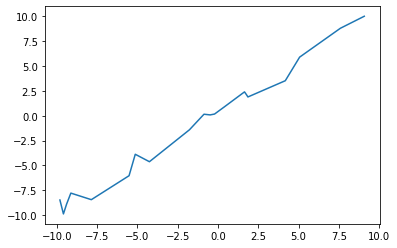

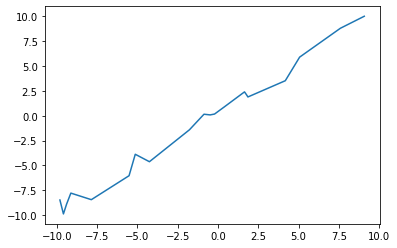

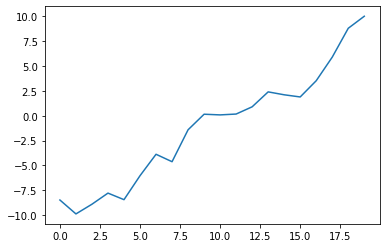

L2
prior = {'sin':0.19, 'affine':0.10, 'sqrt':0.25, 'log':0.10, 2:0.25, 3:0.10, 4:0.10, 5:0.10, 6:0.10}
& 0.19 & 0.10 & 0.25 & 0.10 & 0.25 & 0.10 & 0.10 & 0.10 & 0.10 
[-0.8638138  -0.74541195 -0.74128848 -0.62930283 -0.52833155 -0.4912352
 -0.46939335 -0.30001431 -0.05708536 -0.01916018  0.05161791  0.2409998
  0.27924449  0.43877812  0.55655233  0.69669054  0.88770171  0.8970806
  0.92984988  0.99163059]
[0.96785153 0.85069292 0.84547145 0.6842923  0.52194481 0.46210799
 0.42738867 0.18784103 0.00634092 0.         0.00503914 0.1230311
 0.16369543 0.37971709 0.56777575 0.78527682 0.9822572  0.98692803
 0.99865394 1.        ]


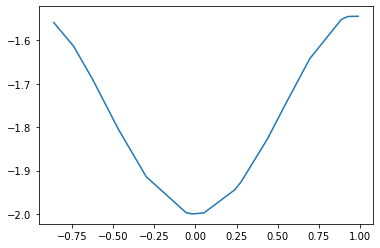

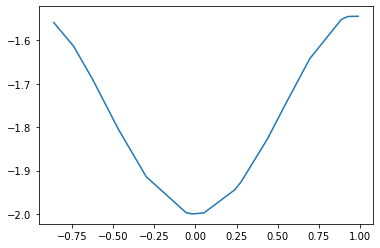

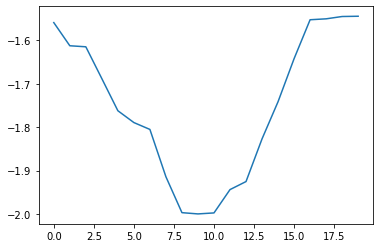

L3
prior = {'sin':0.10, 'affine':0.22, 'sqrt':0.11, 'log':0.11, 2:0.11, 3:0.25, 4:0.10, 5:0.15, 6:0.10}
& 0.10 & 0.11 & 0.11 & 0.22 & 0.11 & 0.25 & 0.10 & 0.15 & 0.10 
[-0.97298259 -0.95145459 -0.71636545 -0.53445466 -0.48777241 -0.4687349
 -0.37874156 -0.36653867 -0.13976803 -0.04935044 -0.03249427  0.11610247
  0.25341295  0.30424919  0.4302865   0.45508722  0.58245486  0.64743534
  0.70649195  0.93841174]
[0.00337484 0.         0.16586864 0.34435431 0.37998722 0.39300681
 0.44274206 0.4480402  0.49720117 0.49998706 0.50007874 0.50178593
 0.51745138 0.53004805 0.58361898 0.5984344  0.69774327 0.76150993
 0.82382488 1.        ]


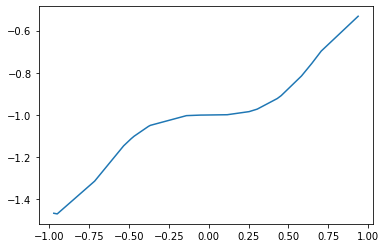

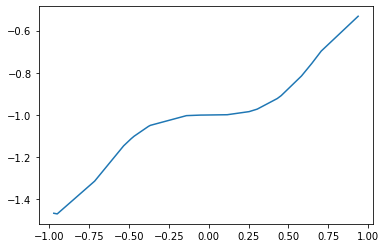

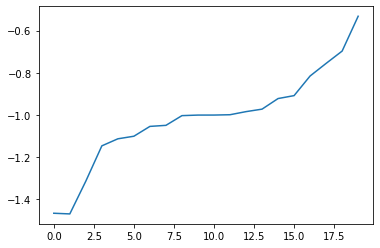

L4
prior = {'sin':0.10, 'affine':0.15, 'sqrt':0.11, 'log':0.11, 2:0.22, 3:0.24, 4:0.22, 5:0.12, 6:0.10}
& 0.10 & 0.11 & 0.11 & 0.15 & 0.22 & 0.24 & 0.22 & 0.12 & 0.10 
[1.32843718e-03 1.06200952e-02 2.27102570e-02 1.02150960e-01
 1.66581959e-01 2.17807478e-01 3.04054454e-01 3.71795206e-01
 5.29299196e-01 5.56650597e-01 8.37273727e-01 1.02244358e+00
 1.04135558e+00 1.27892555e+00 1.38301622e+00 1.40989612e+00
 1.71800528e+00 1.88333559e+00 1.93103328e+00 1.95018936e+00]
[0.         0.21003777 0.28772855 0.4474938  0.50410903 0.53731082
 0.58198153 0.61143704 0.66971867 0.67887701 0.76289562 0.81119612
 0.8158773  0.8712236  0.89364187 0.89926611 0.95937054 0.98867007
 0.99678262 1.        ]


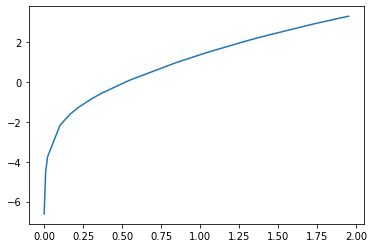

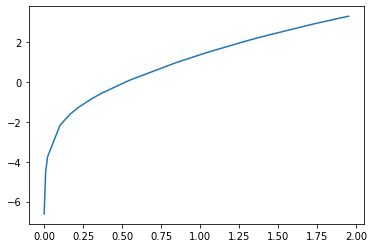

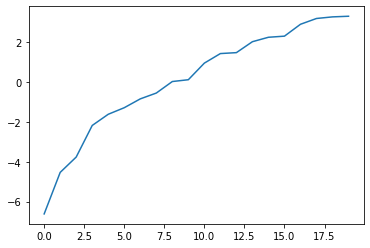

L6
prior = {'sin':0.12, 'affine':0.11, 'sqrt':0.25, 'log':0.21, 2:0.24, 3:0.11, 4:0.11, 5:0.11, 6:0.11}
& 0.12 & 0.21 & 0.25 & 0.11 & 0.24 & 0.11 & 0.11 & 0.11 & 0.11 
[-0.96587903 -0.91418762 -0.79949651 -0.75944531 -0.71808505 -0.29155036
 -0.20416277  0.04915413  0.10487812  0.23011604  0.23531397  0.4017113
  0.50980221  0.51796911  0.54900191  0.72224602  0.7700437   0.82656868
  0.93410984  0.9346756 ]
[0.22092894 0.17075658 0.08945373 0.06916339 0.05183931 0.
 0.00330659 0.02650562 0.03566046 0.06595166 0.06758232 0.14250157
 0.22322868 0.23066444 0.26086535 0.49706724 0.58663803 0.70901983
 0.99826245 1.        ]


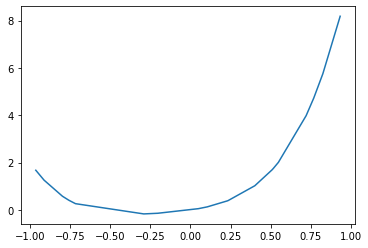

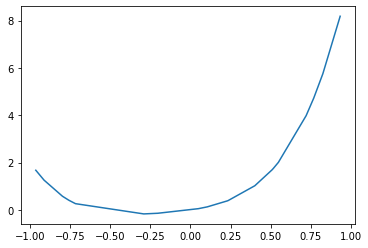

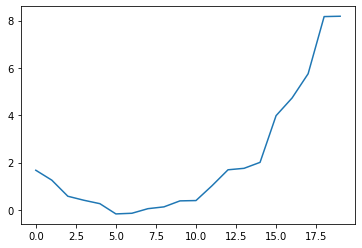

L7
prior = {'sin':0.10, 'affine':0.21, 'sqrt':0.11, 'log':0.11, 2:0.14, 3:0.25, 4:0.11, 5:0.10, 6:0.10}
& 0.10 & 0.11 & 0.11 & 0.21 & 0.14 & 0.25 & 0.11 & 0.10 & 0.10 
[-0.92967988 -0.86785147 -0.67263148 -0.59440792 -0.47440009 -0.46818875
 -0.40810033 -0.28448423 -0.15282473 -0.12348811 -0.11725171 -0.05517242
  0.03797984  0.04412484  0.56679329  0.63272861  0.65629323  0.81246284
  0.85858334  0.97021736]
[0.         0.04025944 0.15686929 0.19982774 0.26241153 0.26555533
 0.29554658 0.35519638 0.41654261 0.43000987 0.43286611 0.46120288
 0.5035758  0.50637227 0.75804371 0.79358652 0.80660511 0.89773186
 0.92646098 1.        ]


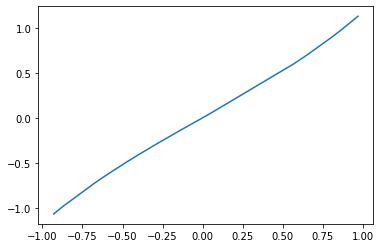

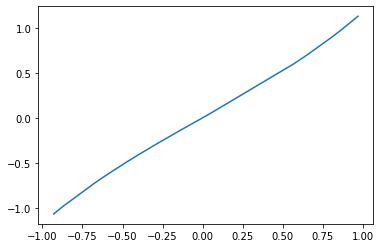

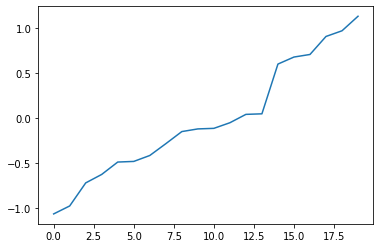

L8
prior = {'sin':0.25, 'affine':0.10, 'sqrt':0.10, 'log':0.10, 2:0.10, 3:0.10, 4:0.10, 5:0.23, 6:0.10}
& 0.25 & 0.10 & 0.10 & 0.10 & 0.10 & 0.10 & 0.10 & 0.23 & 0.10 
[-0.99587073 -0.77895541 -0.74395826 -0.60217733 -0.43828101 -0.34069768
 -0.33911885  0.10516267  0.16638566  0.20664598  0.26166362  0.27678021
  0.45711746  0.58352284  0.70361717  0.89564377  0.91224632  0.92479015
  0.97577834  0.995988  ]
[0.99974273 0.58836272 0.53337237 0.34028671 0.17276698 0.09959085
 0.09856419 0.         0.01565069 0.02982617 0.05422795 0.06195836
 0.18912778 0.31829375 0.47365968 0.79402973 0.82619112 0.85098575
 0.95624806 1.        ]


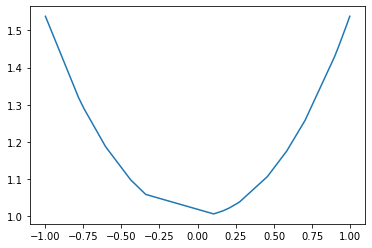

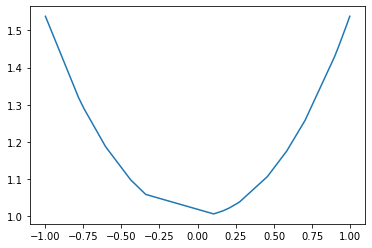

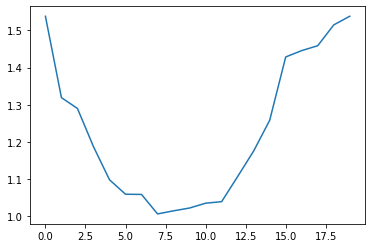

L9
prior = {'sin':0.10, 'affine':0.18, 'sqrt':0.25, 'log':0.25, 2:0.10, 3:0.11, 4:0.10, 5:0.10, 6:0.10}
& 0.10 & 0.25 & 0.25 & 0.18 & 0.10 & 0.11 & 0.10 & 0.10 & 0.10 
[-0.95084595 -0.79510744 -0.79201832 -0.78366895 -0.55756374 -0.53885742
 -0.46258194 -0.44670054 -0.36689958 -0.30020464 -0.21536212 -0.20594834
  0.01268584  0.26796331  0.26797384  0.36745289  0.41282116  0.60051121
  0.65361054  0.91113679]
[0.         0.04504287 0.04549875 0.04668341 0.06611484 0.06737407
 0.07265517 0.07380346 0.0799339  0.08561278 0.09373229 0.09470354
 0.12247072 0.17588024 0.17588322 0.2083599  0.22680443 0.3455271
 0.39964888 1.        ]


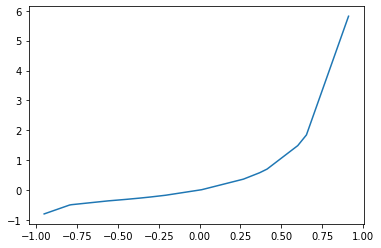

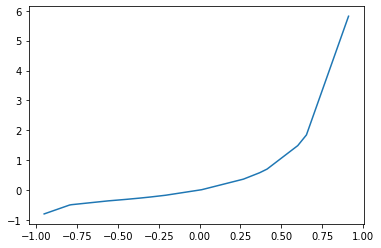

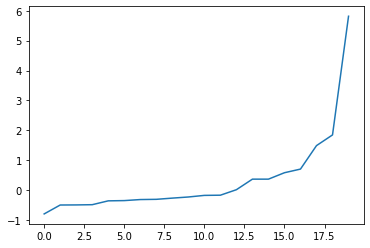

L13
prior = {'sin':0.10, 'affine':0.16, 'sqrt':0.11, 'log':0.11, 2:0.19, 3:0.25, 4:0.24, 5:0.11, 6:0.10}
& 0.10 & 0.11 & 0.11 & 0.16 & 0.19 & 0.25 & 0.24 & 0.11 & 0.10 
[0.07238543 0.41431385 0.54219373 0.62391171 1.05507075 1.19661458
 1.55361647 1.55819403 1.70400955 1.74212616 1.94508835 2.35260584
 2.36234152 2.789321   3.0041292  3.194757   3.57082866 3.69382215
 3.77850287 3.93541532]
[0.         0.28289104 0.34307265 0.37668979 0.5174221  0.55496635
 0.63803963 0.63901754 0.66921449 0.67682199 0.71556555 0.78588157
 0.78745817 0.85272142 0.88305167 0.90877887 0.95667736 0.97160879
 0.98169738 1.        ]


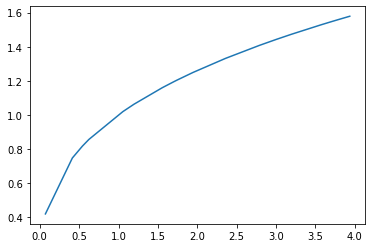

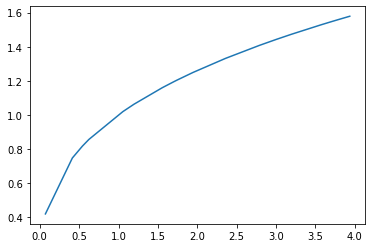

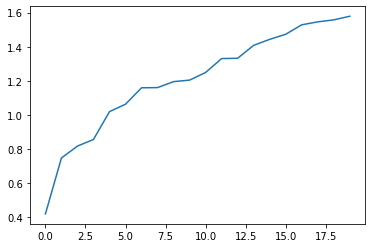

L14
prior = {'sin':0.10, 'affine':0.10, 'sqrt':0.25, 'log':0.25, 2:0.10, 3:0.10, 4:0.10, 5:0.10, 6:0.10}
& 0.10 & 0.25 & 0.25 & 0.10 & 0.10 & 0.10 & 0.10 & 0.10 & 0.10 
[-0.96107507 -0.60201812 -0.44732569 -0.42656663 -0.26504936 -0.26095292
 -0.24021219 -0.20155523 -0.15389112  0.12090118  0.29906845  0.32933117
  0.33643646  0.41374362  0.44053171  0.6323015   0.73372183  0.82290175
  0.85079005  0.85595233]
[0.         0.06051387 0.08210131 0.08548218 0.11814806 0.11915043
 0.12437711 0.13482235 0.14904586 0.2658936  0.38072196 0.4038212
 0.40940551 0.47423437 0.49848255 0.70031487 0.82769514 0.95143901
 0.99232139 1.        ]


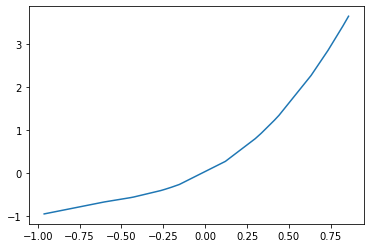

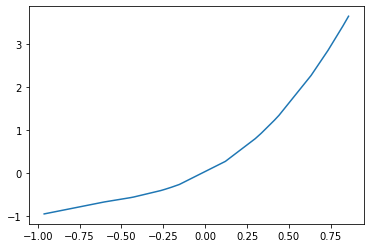

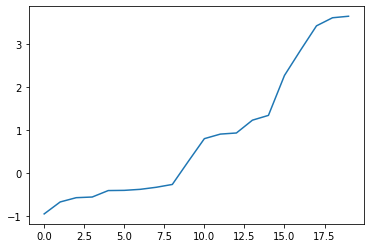

L15
prior = {'sin':0.10, 'affine':0.15, 'sqrt':0.11, 'log':0.12, 2:0.22, 3:0.24, 4:0.19, 5:0.10, 6:0.10}
& 0.10 & 0.12 & 0.11 & 0.15 & 0.22 & 0.24 & 0.19 & 0.10 & 0.10 
[0.16471917 0.20402924 0.39444147 0.59351575 0.67927801 1.23411184
 1.37715666 2.0098123  2.19539707 2.270771   2.50864285 2.61199904
 3.0930365  3.20429952 3.23025522 3.26090016 3.26568412 3.44124271
 3.55306016 3.76873888]
[0.         0.05025634 0.21928534 0.33580797 0.3764378  0.56993967
 0.6080625  0.74606584 0.77984092 0.79290816 0.83199071 0.84805274
 0.9167274  0.93138082 0.93474052 0.93867951 0.93929175 0.96127823
 0.97481833 1.        ]


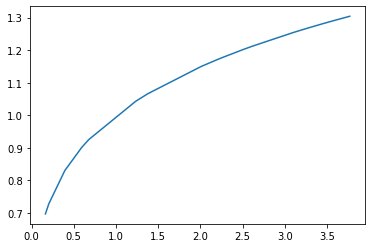

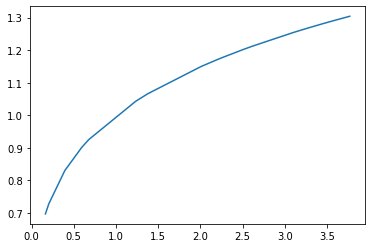

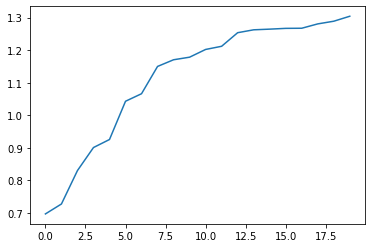

L16
prior = {'sin':0.10, 'affine':0.12, 'sqrt':0.11, 'log':0.11, 2:0.22, 3:0.25, 4:0.24, 5:0.18, 6:0.10}
& 0.10 & 0.11 & 0.11 & 0.12 & 0.22 & 0.25 & 0.24 & 0.18 & 0.10 
[0.01861935 0.25075545 0.3431784  0.41894443 0.46623445 0.47446207
 0.74326699 0.81448373 0.97827844 1.43055614 1.60675274 1.69941568
 1.83284904 2.26524642 2.65678842 3.02962622 3.75302455 3.92899111
 3.93199654 3.97066797]
[0.         0.35477784 0.41144027 0.44935825 0.47031861 0.4737898
 0.56714465 0.58722439 0.62855873 0.71926658 0.74839479 0.76269968
 0.78223978 0.83859569 0.88261874 0.91994842 0.98295784 0.99679545
 0.99702744 1.        ]


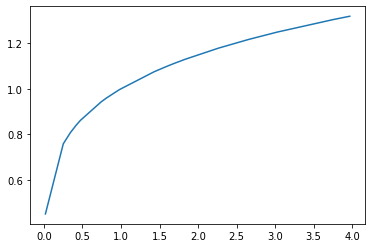

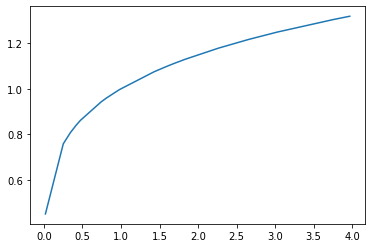

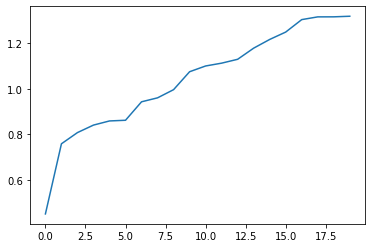

L18
prior = {'sin':0.25, 'affine':0.10, 'sqrt':0.10, 'log':0.10, 2:0.25, 3:0.10, 4:0.22, 5:0.23, 6:0.10}
& 0.25 & 0.10 & 0.10 & 0.10 & 0.25 & 0.10 & 0.22 & 0.23 & 0.10 
[-0.76216612 -0.69753955 -0.66137462 -0.44376697 -0.27231045 -0.20873266
 -0.1649216   0.02416143  0.11058821  0.13857384  0.17221588  0.19663194
  0.38749405  0.56316346  0.5758315   0.61092487  0.83268066  0.91093187
  0.93018995  0.94352615]
[0.86999535 0.78531658 0.73244495 0.38657746 0.15533785 0.09224485
 0.05760162 0.         0.02539771 0.04046083 0.06284427 0.08192759
 0.30270973 0.57752375 0.59802565 0.65427599 0.94267172 0.99142633
 0.99738734 1.        ]


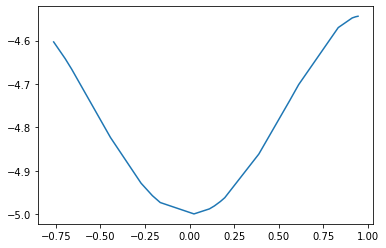

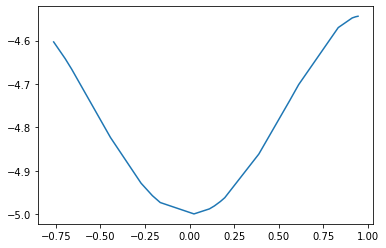

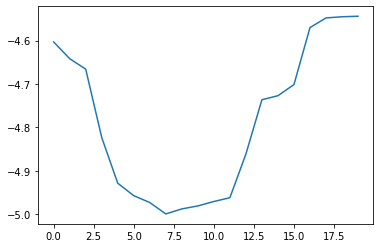

L19
prior = {'sin':0.10, 'affine':0.14, 'sqrt':0.22, 'log':0.24, 2:0.12, 3:0.13, 4:0.14, 5:0.14, 6:0.15}
& 0.10 & 0.24 & 0.22 & 0.14 & 0.12 & 0.13 & 0.14 & 0.14 & 0.15 
[-0.92851463 -0.48124523 -0.39869768 -0.28180582 -0.14000644 -0.08024959
  0.00421116  0.09769266  0.14721949  0.27721836  0.4960456   0.51638743
  0.54025625  0.572377    0.58713474  0.6015972   0.72318193  0.77540167
  0.91009336  0.95857264]
[5.62631731e-02 7.24320279e-04 0.00000000e+00 7.10459219e-03
 2.78169703e-02 4.01459157e-02 6.09149154e-02 8.83691768e-02
 1.04903220e-01 1.56074498e-01 2.81506750e-01 2.96998268e-01
 3.16298422e-01 3.44365180e-01 3.58134814e-01 3.72201857e-01
 5.17104307e-01 5.97239036e-01 8.71572785e-01 1.00000000e+00]


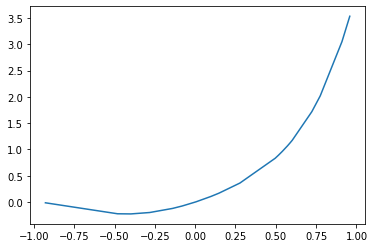

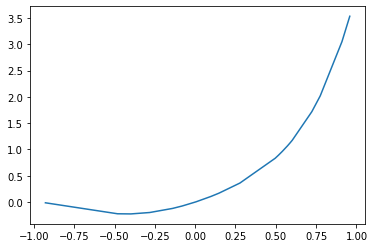

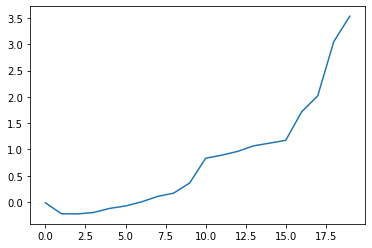

L20
prior = {'sin':0.10, 'affine':0.22, 'sqrt':0.13, 'log':0.11, 2:0.10, 3:0.23, 4:0.10, 5:0.21, 6:0.10}
& 0.10 & 0.11 & 0.13 & 0.22 & 0.10 & 0.23 & 0.10 & 0.21 & 0.10 
[-0.95728263 -0.95046188 -0.89789387 -0.79953313 -0.79536637 -0.72050844
 -0.69527103 -0.41564527 -0.35934743 -0.3388074  -0.33746224 -0.23447156
 -0.0533476   0.32107235  0.35025183  0.66206223  0.69030817  0.89361434
  0.96598022  0.99214254]
[0.04214613 0.05054805 0.11686523 0.24700774 0.25265103 0.35503171
 0.38974909 0.75007909 0.81025878 0.83061846 0.83191988 0.91876003
 1.         0.84745175 0.81938618 0.4353535  0.39657404 0.12237746
 0.0315045  0.        ]


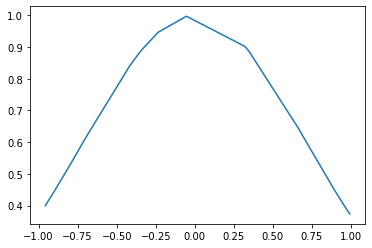

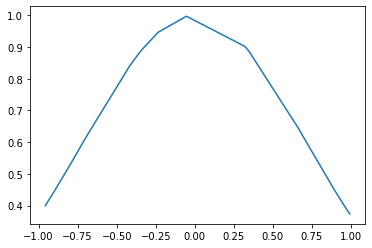

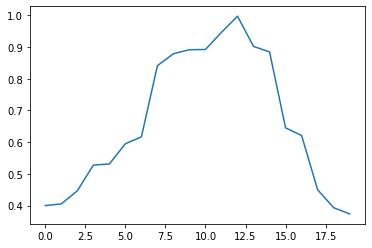

L21
prior = {'sin':0.10, 'affine':0.11, 'sqrt':0.18, 'log':0.24, 2:0.12, 3:0.13, 4:0.14, 5:0.15, 6:0.18}
& 0.10 & 0.24 & 0.18 & 0.11 & 0.12 & 0.13 & 0.14 & 0.15 & 0.18 
[-0.89253291 -0.80437968 -0.66512836 -0.41146767 -0.20755451 -0.12929307
  0.24228065  0.35501671  0.40105725  0.4237409   0.53831105  0.54949523
  0.59091305  0.64380782  0.73422908  0.76615519  0.76872073  0.87572875
  0.93315021  0.98846617]
[0.01283968 0.00206558 0.         0.01163763 0.02660003 0.03379174
 0.08820793 0.11709833 0.13199468 0.14019098 0.19322075 0.19971892
 0.22646122 0.26795664 0.36509819 0.4099682  0.41386661 0.62575839
 0.7917013  1.        ]


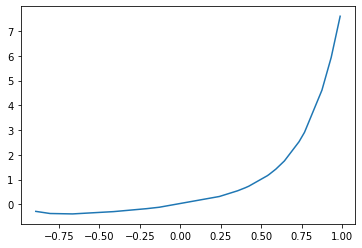

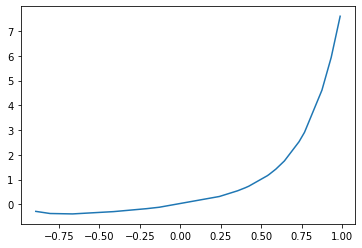

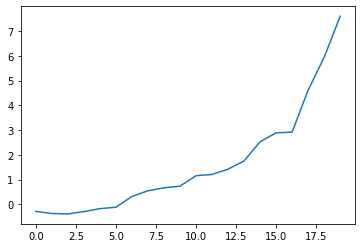

L22
prior = {'sin':0.10, 'affine':0.10, 'sqrt':0.10, 'log':0.10, 2:0.25, 3:0.10, 4:0.23, 5:0.10, 6:0.10}
& 0.10 & 0.10 & 0.10 & 0.10 & 0.25 & 0.10 & 0.23 & 0.10 & 0.10 
[-0.97149697 -0.92574079 -0.91085778 -0.86975706 -0.52495372 -0.4573878
 -0.3899066  -0.31579225 -0.19910293 -0.19824087  0.05542945  0.1159748
  0.22953977  0.3317428   0.53638933  0.64694344  0.73226941  0.82656719
  0.92162506  0.96488977]
[0.         0.07386335 0.09779237 0.16349364 0.66053276 0.73900551
 0.80872509 0.87427069 0.9517129  0.95216111 1.         0.98620721
 0.9346986  0.86119074 0.64646256 0.50010263 0.37637773 0.23171897
 0.08048665 0.01068557]


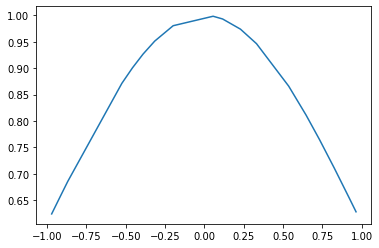

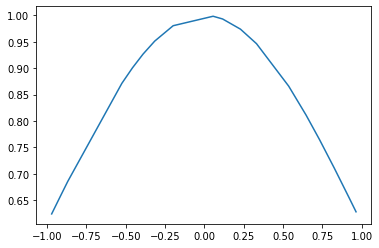

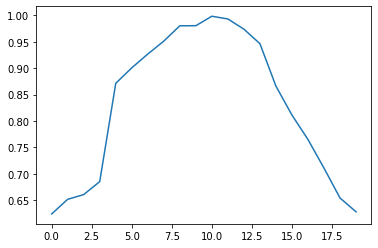

R1
prior = {'sin':0.10, 'affine':0.21, 'sqrt':0.11, 'log':0.11, 2:0.25, 3:0.11, 4:0.10, 5:0.10, 6:0.10}
& 0.10 & 0.11 & 0.11 & 0.21 & 0.25 & 0.11 & 0.10 & 0.10 & 0.10 
[-0.84944544 -0.8435078  -0.66214777 -0.48388157 -0.40821605 -0.39341616
 -0.28822169 -0.25742611 -0.25187475 -0.17243956  0.06464066  0.15518018
  0.37276046  0.37736685  0.38817475  0.40637803  0.5331821   0.56238569
  0.62060416  0.8985598 ]
[0.00000000e+00 2.29327391e-05 2.26226233e-03 1.04532442e-02
 1.73038139e-02 1.89725747e-02 3.47537838e-02 4.09128457e-02
 4.21089352e-02 6.24457548e-02 1.70428313e-01 2.35477751e-01
 4.48304385e-01 4.53515837e-01 4.65823439e-01 4.86785365e-01
 6.37174795e-01 6.71796233e-01 7.39298668e-01 1.00000000e+00]


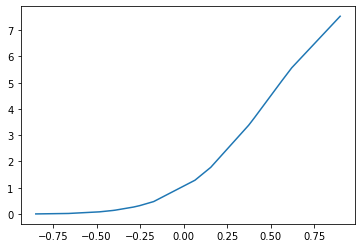

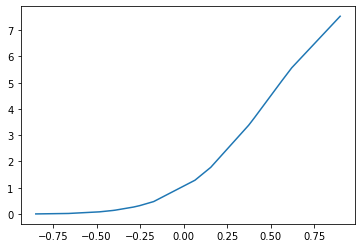

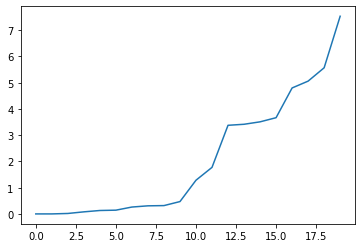

R2
prior = {'sin':0.25, 'affine':0.12, 'sqrt':0.25, 'log':0.25, 2:0.10, 3:0.18, 4:0.10, 5:0.10, 6:0.10}
& 0.25 & 0.25 & 0.25 & 0.12 & 0.10 & 0.18 & 0.10 & 0.10 & 0.10 
[-0.92661716 -0.83241729 -0.70519979 -0.56027845 -0.45140859 -0.44402011
 -0.42569457  0.0322474   0.08670528  0.09651256  0.16047574  0.3199411
  0.41596471  0.479265    0.51257446  0.53442013  0.54975956  0.58656335
  0.88806493  0.91374114]
[1.         0.95693634 0.88914336 0.81543236 0.77330242 0.77102463
 0.76572316 0.7481456  0.74358259 0.74220419 0.72828258 0.64990487
 0.57143792 0.50854109 0.47251544 0.44796882 0.43035128 0.38699572
 0.02673011 0.        ]


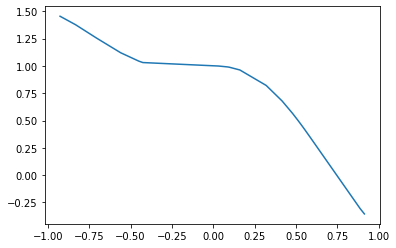

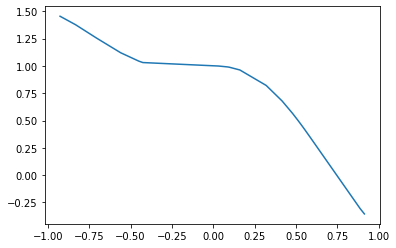

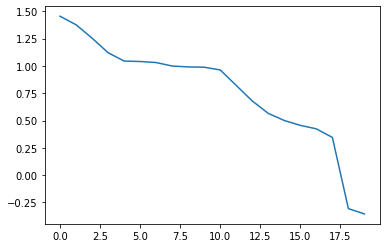

R3
prior = {'sin':0.11, 'affine':0.10, 'sqrt':0.18, 'log':0.25, 2:0.10, 3:0.10, 4:0.10, 5:0.10, 6:0.10}
& 0.11 & 0.25 & 0.18 & 0.10 & 0.10 & 0.10 & 0.10 & 0.10 & 0.10 
[-0.93961445 -0.79778502 -0.66371576 -0.36394274 -0.36324213 -0.31028683
 -0.11104209  0.00478659  0.08009593  0.11226636  0.23499454  0.24025176
  0.29108859  0.40368097  0.5301399   0.74663886  0.7745663   0.91613436
  0.93146856  0.97075713]
[0.08746049 0.         0.05556687 0.18547281 0.18558247 0.19195848
 0.19769317 0.1977303  0.19773759 0.19776951 0.19923912 0.1994113
 0.20199895 0.21792917 0.26770449 0.49548763 0.54212497 0.84893106
 0.88947171 1.        ]


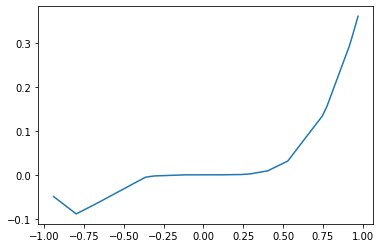

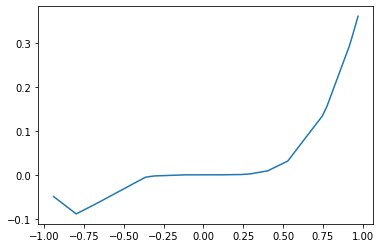

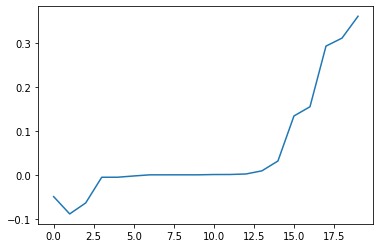

N1
prior = {'sin':0.10, 'affine':0.10, 'sqrt':0.10, 'log':0.25, 2:0.10, 3:0.10, 4:0.10, 5:0.10, 6:0.10}
& 0.10 & 0.25 & 0.10 & 0.10 & 0.10 & 0.10 & 0.10 & 0.10 & 0.10 
[-0.94961942 -0.87984407 -0.76330113 -0.75582879 -0.73538865 -0.61352742
 -0.59962022 -0.59746647 -0.58027905 -0.48079953 -0.37281878 -0.26892194
 -0.02570375  0.07434026  0.28844636  0.34730654  0.37093429  0.79727534
  0.82430191  0.98073704]
[0.         0.03096475 0.07355868 0.07594761 0.08229353 0.1150724
 0.11834068 0.11883943 0.12275137 0.14337679 0.1632002  0.18156214
 0.23195441 0.25974734 0.3429563  0.37308077 0.3862053  0.75035146
 0.78310987 1.        ]


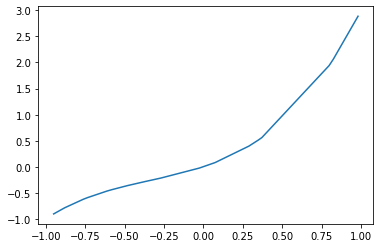

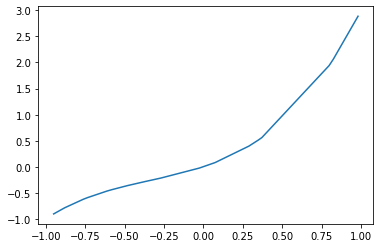

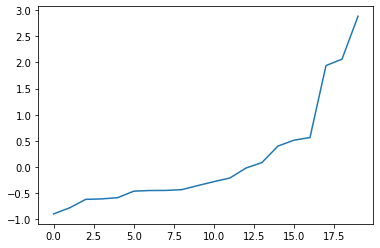

N2
prior = {'sin':0.10, 'affine':0.10, 'sqrt':0.10, 'log':0.18, 2:0.10, 3:0.13, 4:0.14, 5:0.15, 6:0.20}
& 0.10 & 0.18 & 0.10 & 0.10 & 0.10 & 0.13 & 0.14 & 0.15 & 0.20 
[-0.90100051 -0.79629077 -0.78663511 -0.73165272 -0.48987243 -0.40774445
 -0.40249938 -0.36691776 -0.20677978 -0.18245234 -0.07789956 -0.01318608
  0.06795585  0.31408735  0.40395519  0.50107331  0.76952964  0.87032102
  0.88840544  0.99604558]
[0.03471658 0.01049056 0.00893753 0.00197338 0.         0.00661022
 0.00712135 0.01084297 0.03250958 0.03646842 0.05563767 0.06951261
 0.08963295 0.17874386 0.22703464 0.2929085  0.5802491  0.74245128
 0.77547772 1.        ]


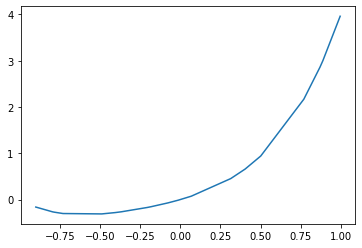

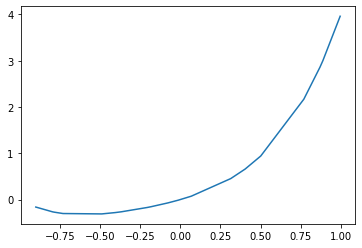

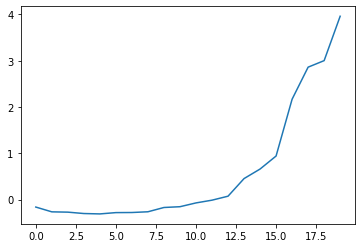

N3
prior = {'sin':0.10, 'affine':0.13, 'sqrt':0.25, 'log':0.25, 2:0.11, 3:0.11, 4:0.11, 5:0.10, 6:0.10}
& 0.10 & 0.25 & 0.25 & 0.13 & 0.11 & 0.11 & 0.11 & 0.10 & 0.10 
[-0.79202384 -0.73662544 -0.45689781 -0.43022896 -0.38962259 -0.20597267
 -0.033082   -0.02063018  0.05316806  0.07589156  0.21509072  0.23055285
  0.40880308  0.41810162  0.58499781  0.67129208  0.7623765   0.81579692
  0.83283802  0.87532619]
[0.         0.01591655 0.06508294 0.06874179 0.07433871 0.1023991
 0.13717    0.14012767 0.15925362 0.16575784 0.21378951 0.22018417
 0.31639388 0.32284151 0.4740412  0.58693654 0.74177294 0.85358707
 0.89300997 1.        ]


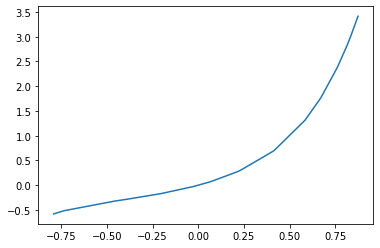

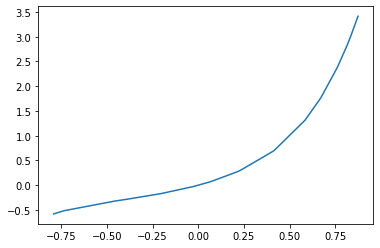

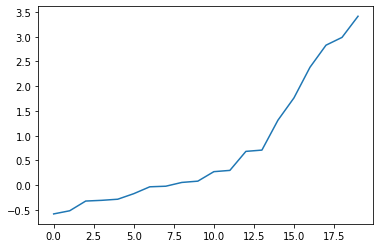

N4
prior = {'sin':0.10, 'affine':0.10, 'sqrt':0.16, 'log':0.25, 2:0.11, 3:0.12, 4:0.12, 5:0.13, 6:0.15}
& 0.10 & 0.25 & 0.16 & 0.10 & 0.11 & 0.12 & 0.12 & 0.13 & 0.15 
[-0.96749442 -0.71912096 -0.60709802 -0.36033222 -0.35705414 -0.11425395
 -0.08255422 -0.05163038  0.02953421  0.28560675  0.34305539  0.35578994
  0.42578461  0.53809399  0.63490653  0.66095269  0.68594659  0.79617551
  0.80426243  0.96686796]
[4.77064330e-02 0.00000000e+00 2.82333836e-04 1.68631383e-02
 1.71684980e-02 4.52341369e-02 4.98430873e-02 5.46070030e-02
 6.85548416e-02 1.33295026e-01 1.54652087e-01 1.59882181e-01
 1.92489114e-01 2.62567308e-01 3.48232318e-01 3.76608592e-01
 4.06377090e-01 5.73791923e-01 5.88812424e-01 1.00000000e+00]


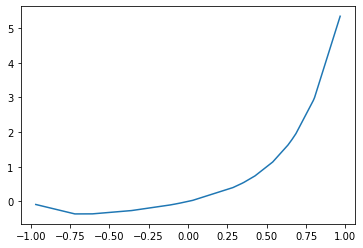

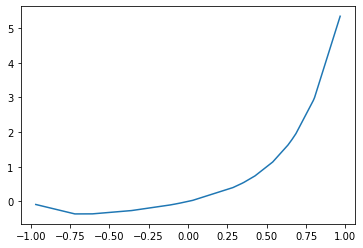

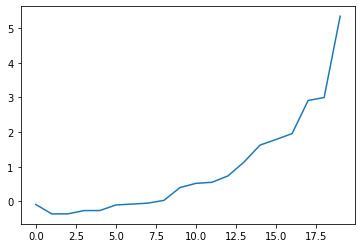

N5
prior = {'sin':0.25, 'affine':0.10, 'sqrt':0.21, 'log':0.10, 2:0.13, 3:0.10, 4:0.10, 5:0.10, 6:0.10}
& 0.25 & 0.10 & 0.21 & 0.10 & 0.13 & 0.10 & 0.10 & 0.10 & 0.10 
[-0.93914697 -0.92391064 -0.91527191 -0.88418145 -0.77550001 -0.61275342
 -0.54451801 -0.41722236 -0.29236193 -0.2810937  -0.25117203 -0.24346437
  0.06298856  0.31572427  0.33433764  0.60413705  0.8007349   0.91308821
  0.92840084  0.96654973]
[0.99777187 0.99419378 0.99144459 0.97739475 0.88332347 0.65363032
 0.54307359 0.34086723 0.17175659 0.15869604 0.12609232 0.11820062
 0.         0.20012707 0.22391678 0.63985589 0.91068478 0.99066849
 0.99541821 1.        ]


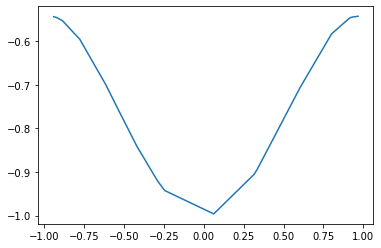

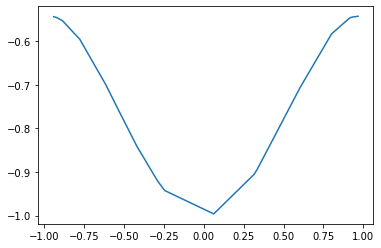

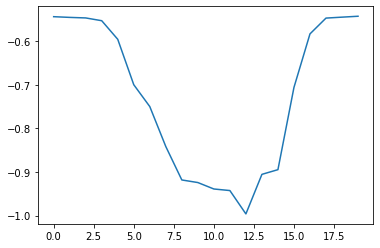

N6
prior = {'sin':0.10, 'affine':0.21, 'sqrt':0.25, 'log':0.24, 2:0.10, 3:0.10, 4:0.10, 5:0.10, 6:0.10}
& 0.10 & 0.24 & 0.25 & 0.21 & 0.10 & 0.10 & 0.10 & 0.10 & 0.10 
[-0.90897857 -0.6040344  -0.55635194 -0.36547961 -0.19045274 -0.17382775
 -0.10641336 -0.01210949  0.10198794  0.17732431  0.20255435  0.33442941
  0.42011661  0.54386173  0.57973901  0.59615804  0.67398073  0.85923748
  0.95854048  0.96093292]
[0.         0.10379094 0.11503311 0.15339411 0.18657605 0.18996666
 0.20454737 0.22793716 0.26272232 0.29070624 0.30112087 0.36540832
 0.41729922 0.50875871 0.53931587 0.55394791 0.62909788 0.85029446
 0.9962291  1.        ]


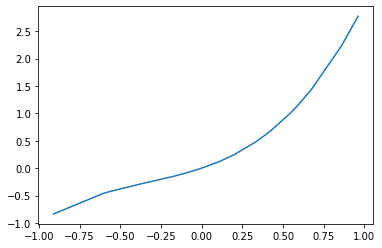

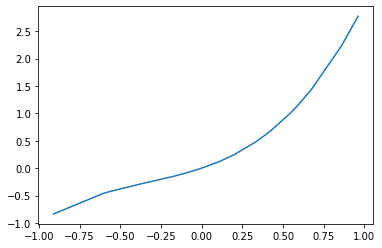

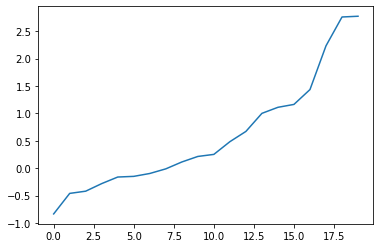

N7
prior = {'sin':0.10, 'affine':0.21, 'sqrt':0.11, 'log':0.12, 2:0.24, 3:0.23, 4:0.11, 5:0.10, 6:0.10}
& 0.10 & 0.12 & 0.11 & 0.21 & 0.24 & 0.23 & 0.11 & 0.10 & 0.10 
[0.14765256 0.21018939 0.30069951 0.62186076 0.85675703 0.98193277
 1.11187538 1.11656685 1.29931299 1.435119   1.47630309 1.48320621
 1.54108812 1.59973087 1.75090265 1.76199612 1.81298825 1.81649676
 1.84631804 1.96514778]
[0.         0.02978126 0.07579746 0.25954954 0.4025408  0.47821577
 0.55522926 0.55797259 0.66248225 0.73692528 0.75893068 0.76259293
 0.79300417 0.82327572 0.89883363 0.90423971 0.92884982 0.93052875
 0.94472511 1.        ]


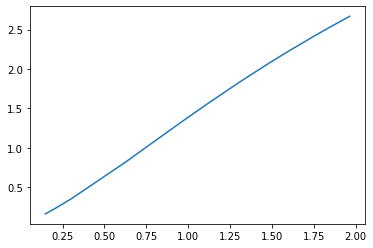

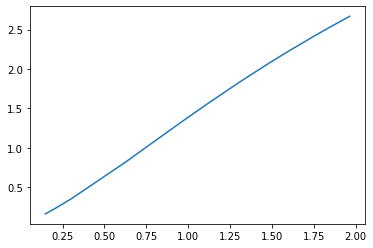

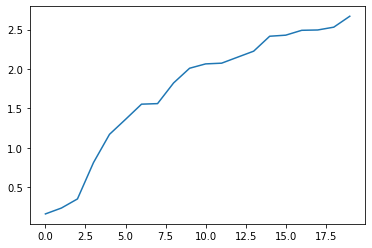

N8
prior = {'sin':0.10, 'affine':0.19, 'sqrt':0.11, 'log':0.11, 2:0.24, 3:0.23, 4:0.11, 5:0.10, 6:0.10}
& 0.10 & 0.11 & 0.11 & 0.19 & 0.24 & 0.23 & 0.11 & 0.10 & 0.10 
[0.23903167 0.50999553 0.55374737 0.77596319 1.19298319 1.39466079
 1.40108483 1.65782614 1.92416979 1.99373914 2.34510929 2.80714305
 3.21951379 3.36256363 3.38923075 3.3953321  3.450237   3.67895192
 3.84306589 3.99341951]
[0.         0.14921443 0.16909082 0.25968414 0.39970243 0.45847889
 0.4602787  0.52910641 0.59507666 0.61154218 0.69062863 0.78607966
 0.86481537 0.89093693 0.8957446  0.89684192 0.90667246 0.94680511
 0.97483826 1.        ]


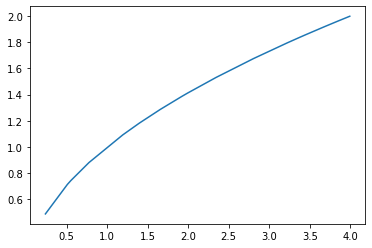

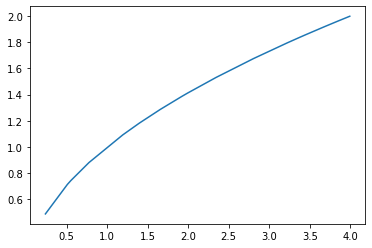

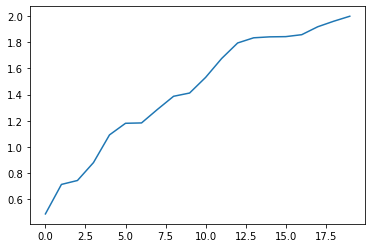

In [209]:
for (d, d1) in zip(data, data1):
    print(d[2])
    latex = '& {:.2f} '.format(d[4][0]) + '& {:.2f} '.format(d[4][3]) + \
            '& {:.2f} '.format(d[4][2]) + '& {:.2f} '.format(d[4][1]) + \
            '& {:.2f} '.format(d[4][4]) + '& {:.2f} '.format(d[4][5]) + \
            '& {:.2f} '.format(d[4][6]) + '& {:.2f} '.format(d[4][7]) + \
            '& {:.2f} '.format(d[4][8])
    priors = 'prior = {'
    for i in range(len(function_set)):
        if isinstance(function_set[i], _Function):
            if function_set[i].name == 'lin':
                priors += "'affine'" + ':{:.2f}'.format(d[4][i]) + ', '
            elif function_set[i].name[:3] == 'pow':
                priors += function_set[i].name[3] + ':{:.2f}'.format(d[4][i]) + ', '
            else:
                priors += "'" + function_set[i].name + "'" + ':{:.2f}'.format(d[4][i]) + ', ' 
        else:
            priors += "'" + function_set[i] + "'" + ':{:.2f}'.format(d[4][i]) + ', '
    priors = priors[:-2] + '}'
    print(priors)
    print(latex)

    plt.plot(d1[0], d1[1])
    plt.show()
    plt.plot(d1[0], d1[1])
    plt.show()
    plt.plot(d1[1])
    plt.show()

In [215]:
for (d, d1) in zip(data2, data2):
    print(d[2])
    latex = '& {:.2f} '.format(d[4][0]) + '& {:.2f} '.format(d[4][3]) + \
            '& {:.2f} '.format(d[4][2]) + '& {:.2f} '.format(d[4][1]) + \
            '& {:.2f} '.format(d[4][4]) + '& {:.2f} '.format(d[4][5]) + \
            '& {:.2f} '.format(d[4][6]) + '& {:.2f} '.format(d[4][7]) + \
            '& {:.2f} '.format(d[4][8])
    priors = 'prior = {'
    for i in range(len(function_set)):
        if isinstance(function_set[i], _Function):
            if function_set[i].name == 'lin':
                priors += "'affine'" + ':{:.2f}'.format(d[4][i]) + ', '
            elif function_set[i].name[:3] == 'pow':
                priors += function_set[i].name[3] + ':{:.2f}'.format(d[4][i]) + ', '
            else:
                priors += "'" + function_set[i].name + "'" + ':{:.2f}'.format(d[4][i]) + ', ' 
        else:
            priors += "'" + function_set[i] + "'" + ':{:.2f}'.format(d[4][i]) + ', '
    priors = priors[:-2] + '}'
    print(priors)
    print(latex)

L1
prior = {'sin':0.10, 'affine':0.21, 'sqrt':0.13, 'log':0.12, 2:0.17, 3:0.22, 4:0.11, 5:0.10, 6:0.10}
& 0.10 & 0.12 & 0.13 & 0.21 & 0.17 & 0.22 & 0.11 & 0.10 & 0.10 
L2
prior = {'sin':0.25, 'affine':0.10, 'sqrt':0.10, 'log':0.10, 2:0.10, 3:0.10, 4:0.10, 5:0.10, 6:0.10}
& 0.25 & 0.10 & 0.10 & 0.10 & 0.10 & 0.10 & 0.10 & 0.10 & 0.10 
L3
prior = {'sin':0.10, 'affine':0.21, 'sqrt':0.11, 'log':0.11, 2:0.16, 3:0.25, 4:0.11, 5:0.15, 6:0.10}
& 0.10 & 0.11 & 0.11 & 0.21 & 0.16 & 0.25 & 0.11 & 0.15 & 0.10 
L4
prior = {'sin':nan, 'affine':nan, 'sqrt':nan, 'log':nan, 2:nan, 3:nan, 4:nan, 5:nan, 6:nan}
& nan & nan & nan & nan & nan & nan & nan & nan & nan 
L6
prior = {'sin':0.25, 'affine':0.11, 'sqrt':0.25, 'log':0.25, 2:0.17, 3:0.11, 4:0.11, 5:0.11, 6:0.11}
& 0.25 & 0.25 & 0.25 & 0.11 & 0.17 & 0.11 & 0.11 & 0.11 & 0.11 
L7
prior = {'sin':0.10, 'affine':0.22, 'sqrt':0.11, 'log':0.11, 2:0.14, 3:0.25, 4:0.10, 5:0.10, 6:0.10}
& 0.10 & 0.11 & 0.11 & 0.22 & 0.14 & 0.25 & 0.10 & 0.10 & 0.10 
L8
prior =

VUMC
prior = {'sin':0.25, 'affine':0.10, 'sqrt':0.10, 'log':0.10, 2:0.24, 3:0.10, 4:0.11, 5:0.24, 6:0.10}


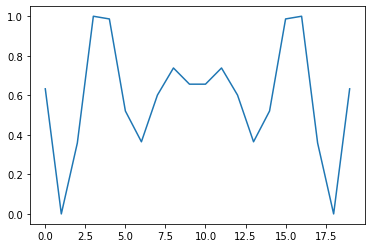

In [166]:
for (d, d1) in zip(data, data):
    print(d[2])
    priors = 'prior = {'
    for i in range(len(function_set)):
        if isinstance(function_set[i], _Function):
            if function_set[i].name == 'lin':
                priors += "'affine'" + ':{:.2f}'.format(d[4][i]) + ', '
            elif function_set[i].name[:3] == 'pow':
                priors += function_set[i].name[3] + ':{:.2f}'.format(d[4][i]) + ', '
            else:
                priors += "'" + function_set[i].name + "'" + ':{:.2f}'.format(d[4][i]) + ', ' 
        else:
            priors += "'" + function_set[i] + "'" + ':{:.2f}'.format(d[4][i]) + ', '
    priors = priors[:-2] + '}'
    print(priors)
    plt.plot(d1[1])
    plt.show()

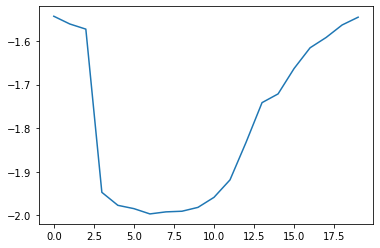

In [102]:
rng = check_random_state(0)
x = rng.uniform(-1, 1, 20)
x.sort()
y = np.sin(x**2)*np.cos(x) - 2.0
plt.plot(y)

Text(0, 0.5, '0.5*x^2 - x')

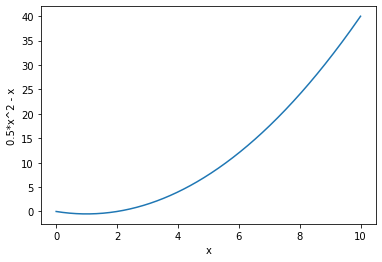

In [99]:
x = np.linspace(0,10,500)
y = 0.5*x**2-x
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("0.5*x^2 - x")

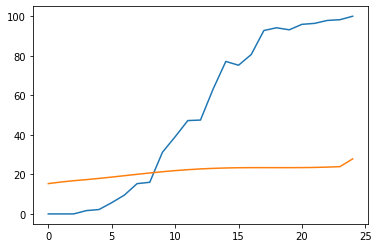

In [171]:
x = [9.210,10.210,10.580,10.830,11.080,11.330,11.580,11.830,12.080,12.330,12.580,12.830,13.080,13.330,13.580,13.830,14.080,14.330,14.580,14.830,15.080,15.330,15.580,15.830,17.580]
y = [0.000,0.000,0.000,1.667,2.222,5.682,9.524,15.315,16.000,31.183,39.000,47.222,47.475,63.208,77.143,75.214,80.612,92.784,94.167,93.137,95.902,96.396,97.872,98.246,100.000]
y1 = []
for i in x:
    ys = 0.205*(-9.409*(2.909*(np.cos(0.447*i))**2*0.926*(-6.09)*0.296*(np.log(0.382*i))**4)-4.725*(-9.929*(np.cos(0.161*i))**6*-4.54*-3.046))
    #ys = 0.495*(-0.708*i*1.764*i*(-0.722)*(np.cos(-4.333*np.log(1.201*i)))**2)
    ys = 1.172*(0.958*i+1.116*np.sin(1.083*i)+0.935*np.sqrt(2.915*i))
    y1.append(ys)
plt.plot(y)
plt.plot(y1)

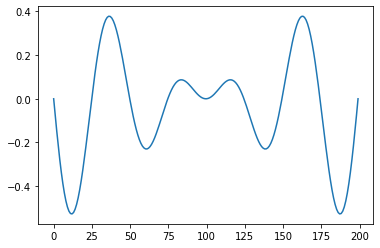

In [174]:
x = np.linspace(-2, 2, 200)
y = 0.3*x*np.sin(2*np.pi*x)
y1 = -0.236*(-0.349*x*3.639*np.sin(2.036*1.437*2.149*x))
plt.plot(y)
#plt.plot(y1)